# Loading all the dependencies

In [1]:
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tqdm import tqdm
from glob import glob
from PIL import Image
import nltk
import string
import warnings
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [2]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=5b00a0796cff1b9cf1ff4fe81383c30c90e220116322b8c48e096d1f634271f0
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [3]:
warnings.filterwarnings("ignore")
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Defining the constants

In [5]:
IMG_H = 224
IMG_W = 224

In [6]:
# Batch size
BATCH_SIZE = 100
# Buffer size
BUFFER_SIZE = 1000

# Defining img file paths

In [7]:
import gdown
import zipfile

image_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
caption_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

os.makedirs("flickr8k", exist_ok=True)

image_zip_path = "flickr8k/Flickr8k_Dataset.zip"
gdown.download(image_url, image_zip_path, quiet=False)

caption_zip_path = "flickr8k/Flickr8k_text.zip"
gdown.download(caption_url, caption_zip_path, quiet=False)

with zipfile.ZipFile(image_zip_path, "r") as zip_ref:
    zip_ref.extractall("flickr8k/")

with zipfile.ZipFile(caption_zip_path, "r") as zip_ref:
    zip_ref.extractall("flickr8k/")

print("Dataset downloaded and extracted.")

Downloading...
From: https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
To: /content/flickr8k/Flickr8k_Dataset.zip
100%|██████████| 1.12G/1.12G [00:09<00:00, 121MB/s]
Downloading...
From: https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
To: /content/flickr8k/Flickr8k_text.zip
100%|██████████| 2.34M/2.34M [00:00<00:00, 38.1MB/s]


Dataset downloaded and extracted.


In [8]:
IMG_FILE_PATH = "/content/flickr8k/Flicker8k_Dataset/"


# Defining txt file paths

In [9]:
BASE_DIR = "/content/flickr8k"
CAP_TEXT_PATH = os.path.join(BASE_DIR, "Flickr8k.token.txt")
TRAIN_TXT_PATH = os.path.join(BASE_DIR, "Flickr_8k.trainImages.txt")
TEST_TXT_PATH = os.path.join(BASE_DIR, "Flickr_8k.testImages.txt")
VAL_TXT_PATH = os.path.join(BASE_DIR, "Flickr_8k.devImages.txt")
TXT_PATH = os.path.join(BASE_DIR, "Flickr_8k.trainImages.txt")
print("Paths updated for Google Colab!")

Paths updated for Google Colab!


# Utility Functions to load and clean images


In [10]:
def all_img_name_vector(images_path: str, ext: str = r".jpg") -> list:
    images_path_list = glob(images_path + '*.jpg')
    print(f"{len(images_path_list)} images found from {images_path}.")
    return images_path_list


In [11]:
def cnn_model() -> tf.keras.Model:
    model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
    model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-1].output)
    print(model.summary())
    return model

In [12]:
def load_img(image_path: str, img_h: str = IMG_H, img_w: str = IMG_W) -> (object, str):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (img_h, img_w))
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img, image_path

In [13]:
def load_doc(filename: str) -> str:
    with open(filename, 'r') as file:
        text = file.read()
    return text

In [14]:
def load_set(text_file_path: str) -> set:
    doc = load_doc(text_file_path)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [15]:
def img_name_2_path(image_name: str, img_file_path: str = IMG_FILE_PATH, ext: str = r".jpg") -> str:
    image_path = img_file_path + str(image_name) + ext
    return image_path

In [16]:
def load_img_dataset(txt_path: str, batch_size=BATCH_SIZE):
    img_name_vector = list(load_set(txt_path)) # Select first 100 images
    img_path_list = list(map(img_name_2_path, img_name_vector))
    encode_train = sorted(img_path_list)

    image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
    image_dataset = image_dataset.map(load_img, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)

    return image_dataset


# Features extractraction

## Loading the train images

In [17]:
TRAIN_TXT_PATH

'/content/flickr8k/Flickr_8k.trainImages.txt'

In [18]:
image_train_dataset = load_img_dataset(TRAIN_TXT_PATH)

In [19]:
image_train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

## Creating our image features extraction model

In [20]:
image_features_extract_model = cnn_model()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

None


## Extracting features and saving it in the same dir

In [21]:
if str(input("Do you want to extract the features of the images[y/Y]: ")).casefold() == 'y':
    for img, path in tqdm(image_train_dataset):
        batch_features = image_features_extract_model(img)
        batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
        for bf, p in zip(batch_features, path):
            path_of_feature = p.numpy().decode("utf-8")
            np.save(path_of_feature, bf.numpy())

Do you want to extract the features of the images[y/Y]: y


100%|██████████| 60/60 [00:52<00:00,  1.14it/s]


## Loading the test images

In [22]:
TEST_TXT_PATH

'/content/flickr8k/Flickr_8k.testImages.txt'

In [23]:
image_test_dataset = load_img_dataset(TEST_TXT_PATH)

## Extracting features and saving it in the same dir

In [24]:
if str(input("Do you want to extract the features of the images[y/Y]: ")).casefold() == 'y':
    for img, path in tqdm(image_train_dataset):
        batch_features = image_features_extract_model(img)
        batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
        for bf, p in zip(batch_features, path):
            path_of_feature = p.numpy().decode("utf-8")
            np.save(path_of_feature, bf.numpy())


Do you want to extract the features of the images[y/Y]: n


# Word/Sentence preprocessing

## Helper functions

In [25]:
def clean_cap(caption: str) -> str:
    cap = ''.join([ch for ch in caption if ch not in string.punctuation])
    cap = cap.split()
    cap = [word.casefold() for word in cap]
    cap = [word for word in cap if len(word) > 1]
    cap = [word for word in cap if word.isalpha()]
    lemmatizer = nltk.WordNetLemmatizer()
    cap = [lemmatizer.lemmatize(word) for word in cap]
    return ' '.join(cap)

In [26]:
def load_cap(caption_txt_path: str) -> dict:
    with open(caption_txt_path, 'r', encoding='utf-8') as caption_txt:
        captions_list = caption_txt.readlines()
    mapping = dict()
    for line in captions_list:
        caption = line.split('\t')
        image_name = caption[0][:-2].split('.')[0]
        image_caption = clean_cap(caption[-1][:-1])
        image_caption = 'startofseq ' + image_caption + ' endofseq'
        if image_name in mapping:
            mapping[image_name].append(image_caption)
        else:
            mapping[image_name] = [image_caption]
    return mapping


In [27]:
def save_captions(mapping: dict, filename: str) -> bool:
    lines = [key + ' ' + cap for key, cap_list in mapping.items() for cap in cap_list]
    with open(filename, 'w') as file:
        file.write('\n'.join(lines))
    return True


In [28]:
def load_doc(filename: str) -> str:
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

In [29]:
def load_set(text_file_path: str) -> set:
    doc = load_doc(text_file_path)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [30]:
def load_clean_cap(caption_txt_path: str, dataset: set) -> dict:
    doc = load_doc(caption_txt_path)
    clean_captions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_name, image_cap = tokens[0], " ".join(tokens[1:])
        if image_name in dataset:
            if image_name not in clean_captions:
                clean_captions[image_name] = list()
            clean_captions[image_name].append(image_cap)
    return clean_captions


In [31]:
def max_len(clean_captions: dict) -> int:
    clean_captions_list = [caption.split() for captions in clean_captions.values()
                           for caption in captions]
    return max(len(caption) for caption in clean_captions_list)

In [32]:
def create_tokenizer(captions_dict: dict, top_k: int = 2000) -> Tokenizer:
    clean_captions_list = [caption for captions in captions_dict.values()
                           for caption in captions]
    tokenizer = Tokenizer(num_words=top_k, oov_token="<unk>")
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    tokenizer.fit_on_texts(clean_captions_list)
    return tokenizer

In [33]:
def path_cap_list(img_names_set: set, tokenizer: Tokenizer, captions_dict) -> (list, list):
    tokenized_caps_dict = tokenize_cap(tokenizer, captions_dict)
    image_name_list = sorted(img_names_set)
    capt_list = [cap for name in image_name_list for cap in tokenized_caps_dict[name]]
    img_path_list = [img_name_2_path(name) for name in image_name_list for i in range(len(tokenized_caps_dict[name]))]
    return img_path_list, capt_list

In [34]:
def load_npy(image_path: str, cap: str) -> (str, str):
    """
    :returns image tensor vector with the image path
    :param image_path:
    :param cap:
    """
    img_tensor = np.load(image_path.decode('utf-8') + '.npy')
    return img_tensor, cap

In [35]:
def create_dataset(img_path_list: str, cap_list: str) -> object:
    """
    :param img_path_list: The ordered list of img paths with duplication acc to number of captions
    :param cap_list: the padded caption list with the curr order
    :return: dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices((img_path_list, cap_list))
    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_npy, [item1, item2], [tf.float32, tf.int32]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [36]:
CAP_TEXT_PATH

'/content/flickr8k/Flickr8k.token.txt'

Pre processing is also done while loading the captions

In [37]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [38]:
cap_dict = load_cap(CAP_TEXT_PATH)

Finding the maximum len of the captption

In [39]:
MAX_CAP_LEN = max_len(cap_dict)
print(MAX_CAP_LEN)

34


In [40]:
def tokenize_cap(tokenizer: Tokenizer, captions_dict: dict, pad_len: int = MAX_CAP_LEN) -> dict:
    pad_caps_dict = {img_name: pad_sequences(tokenizer.texts_to_sequences(captions), maxlen=pad_len, padding='post')
                     for img_name, captions in captions_dict.items()}
    return pad_caps_dict

In [41]:
CLEAN_CAP_TEXT_PATH = "/content/flickr8k/Flickr8k_clean_cap.txt"

## Saving the clean captions

In [42]:
save_captions(cap_dict,CLEAN_CAP_TEXT_PATH)

True

# Tokenizing words

## Loading the train img names

In [43]:
train_img_names = sorted(load_set(TRAIN_TXT_PATH))

Loading the train img captions as a dict

In [44]:
train_img_cap = load_clean_cap(CLEAN_CAP_TEXT_PATH, train_img_names)

In [45]:
len(train_img_cap)

6000

In [46]:
for x in train_img_cap.values():
    print(x)
    break

['startofseq child in pink dress is climbing up set of stair in an entry way endofseq', 'startofseq girl going into wooden building endofseq', 'startofseq little girl climbing into wooden playhouse endofseq', 'startofseq little girl climbing the stair to her playhouse endofseq', 'startofseq little girl in pink dress going into wooden cabin endofseq']


## Creating a tokenizer for training set

In [47]:
tokenizer = create_tokenizer(train_img_cap)

In [48]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(VOCAB_SIZE)

6537


In [49]:
tokenizer.word_index

{'<unk>': 1,
 'startofseq': 2,
 'endofseq': 3,
 'in': 4,
 'the': 5,
 'on': 6,
 'dog': 7,
 'is': 8,
 'and': 9,
 'with': 10,
 'man': 11,
 'of': 12,
 'two': 13,
 'boy': 14,
 'girl': 15,
 'woman': 16,
 'white': 17,
 'black': 18,
 'are': 19,
 'to': 20,
 'wearing': 21,
 'at': 22,
 'people': 23,
 'water': 24,
 'brown': 25,
 'red': 26,
 'young': 27,
 'child': 28,
 'an': 29,
 'his': 30,
 'blue': 31,
 'running': 32,
 'through': 33,
 'playing': 34,
 'shirt': 35,
 'while': 36,
 'ball': 37,
 'down': 38,
 'standing': 39,
 'little': 40,
 'grass': 41,
 'snow': 42,
 'person': 43,
 'jumping': 44,
 'over': 45,
 'three': 46,
 'stand': 47,
 'jump': 48,
 'sitting': 49,
 'field': 50,
 'run': 51,
 'front': 52,
 'it': 53,
 'holding': 54,
 'play': 55,
 'small': 56,
 'yellow': 57,
 'green': 58,
 'group': 59,
 'up': 60,
 'by': 61,
 'large': 62,
 'one': 63,
 'walking': 64,
 'her': 65,
 'men': 66,
 'mouth': 67,
 'air': 68,
 'player': 69,
 'into': 70,
 'rock': 71,
 'near': 72,
 'beach': 73,
 'street': 74,
 'another'

# Train dataset

## Tokenizing the train captions and storing it in lists

In [50]:
img_name_train, caption_train = path_cap_list(train_img_names, tokenizer, train_img_cap)

In [51]:
img_name_train[:10]

['/content/flickr8k/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/flickr8k/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/flickr8k/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/flickr8k/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/flickr8k/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/flickr8k/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/flickr8k/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/flickr8k/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/flickr8k/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/flickr8k/Flicker8k_Dataset/1001773457_577c3a7d70.jpg']

In [52]:
caption_train[:10]

[array([  2,  28,   4,  90, 142,   8, 121,  60, 367,  12, 358,   4,  29,
          1, 618,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0], dtype=int32),
 array([  2,  15, 316,  70, 197, 110,   3,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0], dtype=int32),
 array([   2,   40,   15,  121,   70,  197, 1840,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0], dtype=int32),
 array([   2,   40,   15,  121,    5,  358,   20,   65, 1840,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0], dtype=int32),
 array([  2,  40,  15,   4,  90, 142, 316,  70, 197,   1,   3,   0,   0,
       

## Creating train dataset

In [53]:
train_dataset = create_dataset(img_name_train, caption_train)

# Test Dataset

## Loading the test img names

In [54]:
test_img_names = sorted(load_set(TEST_TXT_PATH))

## Loading the test img captions as a dict

In [55]:
test_img_cap = load_clean_cap(CLEAN_CAP_TEXT_PATH, test_img_names)

In [56]:
len(test_img_cap)

1000

## Creating the test dataset

In [57]:
img_name_test, caption_test = path_cap_list(test_img_names, tokenizer, test_img_cap)

In [58]:
test_dataset = create_dataset(img_name_test, caption_test)

# Defining some constants

In [59]:
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1 # 6537
num_steps = len(train_img_names) // BATCH_SIZE  # 187
EPOCHS = 20
# Shape from last layer of VGG-16 :(7,7,512)
# So, say there are 49 pixel locations now and each pixel is 512 dimensional
features_shape = 512
attention_features_shape = 49

# Model

In [60]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [61]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [62]:
def rnn_type(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                        return_sequences=True,
                                        return_state=True,
                                        recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_activation='sigmoid',
                                   recurrent_initializer='glorot_uniform')

In [63]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#     self.gru = rnn_type(self.units)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, MAX_CAP_LEN, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * MAX_CAP_LEN, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * MAX_CAP_LEN, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [64]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    # Use a simple GRU without return_state and return_sequences
    self.gru = tf.keras.layers.GRU(
        self.units,
        return_sequences=True,
        recurrent_initializer='glorot_uniform'
    )

    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    # Use GRU without return_state for simplicity
    output = self.gru(x)

    # Get the last time step's output as the new hidden state
    state = output[:, -1, :]

    # shape == (batch_size, MAX_CAP_LEN, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * MAX_CAP_LEN, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * MAX_CAP_LEN, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [65]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [66]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

# Checkpoint

In [67]:
checkpoint_path = "/content/drive/MyDrive/flickr8k/checkpoints"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [68]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [69]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [70]:
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['startofseq']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [71]:
# Loading weights
if str(input("Do you want to load weights ? [y/Y] ")).casefold() == 'y':
  encoder.load_weights("/content/drive/MyDrive/flickr8k/Encoder_train_1_8k.weights.h5")
  decoder.load_weights("/content/drive/MyDrive/flickr8k/Decoder_train_1_8k.weights.h5")

Do you want to load weights ? [y/Y] n


In [72]:
import os

file_path = "/content/drive/MyDrive/flickr8k/Flicker8k_Dataset/1244485675_822e6efe60.jpg.npy"
print("File exists:", os.path.exists(file_path))


File exists: False


In [73]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.5572
Epoch 1 Batch 100 Loss 1.5607
Epoch 1 Batch 200 Loss 1.3450
Epoch 1 Loss 7.041316
Time taken for 1 epoch 442.21 sec

Epoch 2 Batch 0 Loss 1.1667
Epoch 2 Batch 100 Loss 1.0398
Epoch 2 Batch 200 Loss 1.0064
Epoch 2 Loss 5.449155
Time taken for 1 epoch 434.13 sec

Epoch 3 Batch 0 Loss 0.9890
Epoch 3 Batch 100 Loss 0.9507
Epoch 3 Batch 200 Loss 0.9521
Epoch 3 Loss 4.946234
Time taken for 1 epoch 436.93 sec

Epoch 4 Batch 0 Loss 1.0086
Epoch 4 Batch 100 Loss 0.7839
Epoch 4 Batch 200 Loss 0.9759
Epoch 4 Loss 4.614067
Time taken for 1 epoch 435.57 sec

Epoch 5 Batch 0 Loss 0.8584
Epoch 5 Batch 100 Loss 0.8430
Epoch 5 Batch 200 Loss 0.8835
Epoch 5 Loss 4.345394
Time taken for 1 epoch 434.36 sec



In [74]:
print("img_tensor shape:", img_tensor.shape)
print("target shape:", target.shape)

img_tensor shape: (100, 49, 512)
target shape: (100, 34)


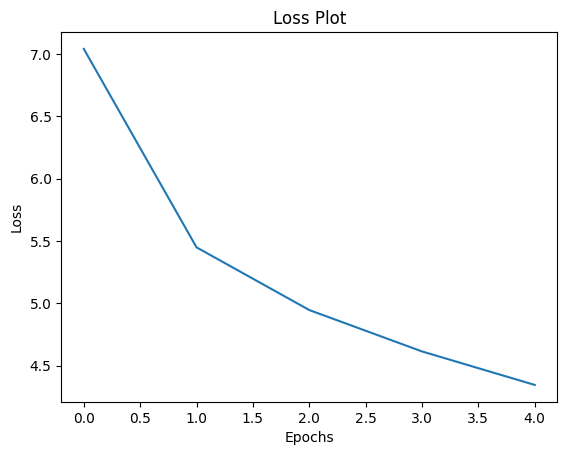

In [75]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Saving Weights

In [76]:
if not os.path.isfile("Encoder_train_1_8k.weights.h5"):
    encoder.save_weights("Encoder_train_1_8k.weights.h5")
    print("Encoder weights saved")


Encoder weights saved


In [77]:
if not os.path.isfile("Decoder_train_1_8k.weights.h5"):
    decoder.save_weights("Decoder_train_1_8k.weights.h5")
    print("Decoder weights saved")


Decoder weights saved


In [78]:
def evaluate(image):
    attention_plot = np.zeros((MAX_CAP_LEN, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_img(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['startofseq']], 0)
    result = []

    for i in range(MAX_CAP_LEN):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == 'endofseq':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [79]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result - 1):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

# Validation

In [80]:
VAL_TXT_PATH = "/content/drive/MyDrive/flickr8k/Flickr_8k.devImages.txt"

In [81]:
val_img_names = sorted(load_set(TEST_TXT_PATH))

In [82]:
val_img_cap = load_clean_cap(CLEAN_CAP_TEXT_PATH, val_img_names)

In [83]:
len(val_img_cap)

1000

In [127]:
image_name = val_img_names[np.random.randint(0, len(val_img_names))]
img_path = img_name_2_path(image_name)
real_captions = val_img_cap[image_name]

In [128]:
result, attention_plot = evaluate(img_path)
print('Prediction Caption:', ' '.join(result[:-1]))
print('Real Captions:')
for i, cap in enumerate(real_captions):
    print(f"{i+1}) {cap[10:-8]}")


Prediction Caption: the black dog is fetch the man toy
Real Captions:
1)  black dog jumping to catch rope toy 
2)  black dog playing fetch with ball of rope 
3)  black dog pounce to get rope toy 
4)  black dog running after his rope toy 
5)  large black dog is playing in grassy yard 


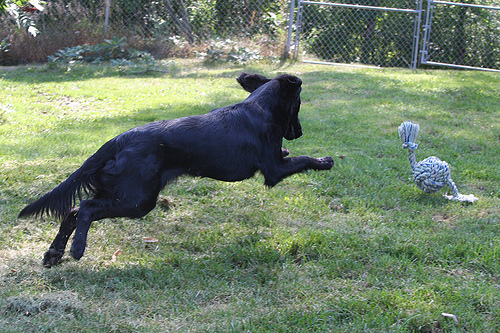

In [129]:
Image.open(img_path)

In [130]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score

nltk.download('wordnet')
nltk.download('omw-1.4')

def calculate_metrics(pred_caption, real_captions):

    pred_tokens = pred_caption.split()
    real_tokens = [caption.split() for caption in real_captions]
    smoothie = SmoothingFunction().method1
    bleu_1 = sentence_bleu(real_tokens, pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie)  # BLEU-1
    bleu_2 = sentence_bleu(real_tokens, pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)  # BLEU-2
    bleu_3 = sentence_bleu(real_tokens, pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)  # BLEU-3
    bleu_4 = sentence_bleu(real_tokens, pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)  # BLEU-4

    # ROUGE Score Calculation
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(pred_caption, cap) for cap in real_captions]
    avg_rouge = {
        "rouge1": sum([s['rouge1'].fmeasure for s in rouge_scores]) / len(rouge_scores),
        "rouge2": sum([s['rouge2'].fmeasure for s in rouge_scores]) / len(rouge_scores),
        "rougeL": sum([s['rougeL'].fmeasure for s in rouge_scores]) / len(rouge_scores),
    }

    # METEOR Score Calculation (Fixed)
    meteor_scores = [meteor_score([cap.split()], pred_tokens) for cap in real_captions]  # Pass tokenized captions
    avg_meteor = sum(meteor_scores) / len(meteor_scores)

    return {
        "BLEU-1": bleu_1,
        "BLEU-2": bleu_2,
        "BLEU-3": bleu_3,
        "BLEU-4": bleu_4,
        "ROUGE-1": avg_rouge["rouge1"],
        "ROUGE-2": avg_rouge["rouge2"],
        "ROUGE-L": avg_rouge["rougeL"],
        "METEOR": avg_meteor
    }

predicted_caption = ' '.join(result[:-1])  # Extracting predicted caption
metrics = calculate_metrics(predicted_caption, real_captions)

print("\nEvaluation Scores:")
for metric, score in metrics.items():
    print(f"{metric}: {score:.4f}")



Evaluation Scores:
BLEU-1: 0.5516
BLEU-2: 0.3729
BLEU-3: 0.2767
BLEU-4: 0.1378
ROUGE-1: 0.3451
ROUGE-2: 0.1550
ROUGE-L: 0.3451
METEOR: 0.3267


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
